In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,date
%matplotlib inline

In [20]:
# Question 1
df = pd.read_csv('monthlyRets-clean.csv')

In [133]:
def plot(date, df1):
    for idx in df1.columns:
        plt.plot(date, df1[idx])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('DATE')
    plt.ylabel('value')
    plt.show()

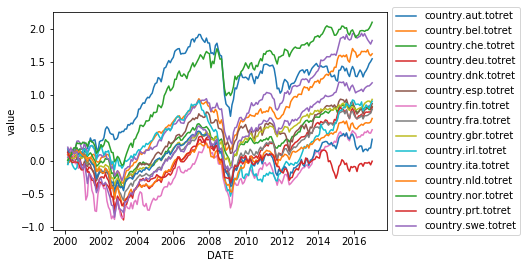

In [220]:
df1 = df[df.columns[range(2,32,2)]].copy()
df2 = df[df.columns[range(1,31,2)]].copy() # saves usdcap data
date = pd.to_datetime(df['DATE'])
plot(date, df1.cumsum())

In [232]:
# Question 2
def con_num(shrkg):
    R = np.array(df1.corr())
    S = np.diag([df1[idx].std() for idx in df1.columns])
    Iden = np.identity(len(R))
    C = S.dot(shrkg * R + (1 - shrkg) * Iden).dot(S)
    return C

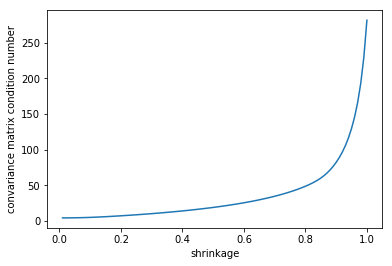

In [252]:
plt.plot(np.linspace(0.01, 1, 100), [np.linalg.cond(con_num(i)) for i in np.linspace(0.01, 1, 100)])
plt.xlabel('shrinkage')
plt.ylabel('convariance matrix condition number')
plt.show()

In [221]:
# Question 3
import re

In [244]:
def get_view(time):
    # return list [P, Omega, q]
    NOR_EUR_COUNTRIES = ('nor', 'swe', 'dnk', 'fin')
    cap_country = [col for col in df2 if col.split('.')[1] not in NOR_EUR_COUNTRIES ]
    w_sum = sum(df2[cap_country].iloc[time])
    P = [- df2[country].iloc[time] / w_sum if country in cap_country else 0.25 for country in df2.columns]
    return np.asarray(P).reshape(1,-1), np.asarray(0.015).reshape(1,1), np.asarray(0.01)

In [245]:
get_view(-1)

(array([[-0.00524669, -0.03461577, -0.13869433, -0.15818016,  0.25      ,
         -0.06388425,  0.25      , -0.19825591, -0.27201363, -0.0106279 ,
         -0.04480673, -0.06999043,  0.25      , -0.00368419,  0.25      ]]),
 array([[ 0.015]]),
 array(0.01))

In [259]:
# Question 4
def BlackLittermanOpt(tau=0.01, kappa=1, time = -1):
    P, Omega, q = get_view(time)
    Sigma = con_num(0.5)
    C = tau * Sigma
    heq = df2.iloc[time].values.reshape(-1,1)
    heq /= np.sum(heq)
    Pi = kappa * (1 + tau) * Sigma.dot(heq)
    H_inv = np.linalg.inv(P.transpose().dot(np.linalg.inv(Omega)).dot(P) + np.linalg.inv(C))
    h_opt = 1/kappa * np.linalg.inv(H_inv + Sigma).dot(H_inv).dot(P.transpose().dot(np.linalg.inv(Omega)).dot(q) + np.linalg.inv(C).dot(Pi))
    return h_opt, heq

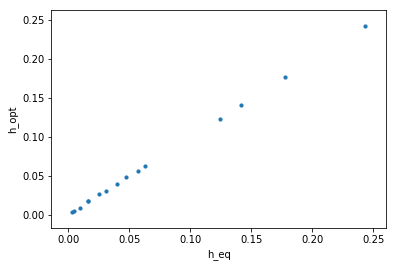

In [260]:
h_opt, heq = BlackLittermanOpt()
plt.scatter(heq, h_opt, s=10)
plt.xlabel('h_eq')
plt.ylabel('h_opt')
plt.show()

In [273]:
BlackLittermanOpt()[0]

array([[ 0.0046624 ],
       [ 0.03076079],
       [ 0.12324864],
       [ 0.14056444],
       [ 0.0268338 ],
       [ 0.05676978],
       [ 0.01755274],
       [ 0.17617715],
       [ 0.24172084],
       [ 0.00944432],
       [ 0.03981683],
       [ 0.06219595],
       [ 0.01793963],
       [ 0.0032739 ],
       [ 0.04903878]])

Posterior dosen't move away much from the prior. It is not highly influenced by the view (comparing to P).

In [274]:
# Question 5

def helper(ti, flag):
    return BlackLittermanOpt(time = ti - 1)[flag].transpose().dot(df1.iloc[ti])


def backtesting():
    pnl_eq = [helper(ti, 0) for ti in range(df.shape[0]//4, df.shape[0])]
    pnl_opt = [helper(ti, 1) for ti in range(df.shape[0]//4, df.shape[0])]
    return pnl_eq, pnl_opt
    

In [276]:
pnl_eq, pnl_opt = backtesting()

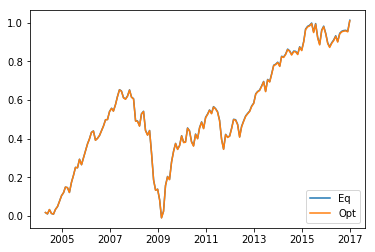

In [278]:
plt.plot(date[df.shape[0]//4:], np.cumsum(pnl_eq), label='Eq')
plt.plot(date[df.shape[0]//4:], np.cumsum(pnl_opt), label='Opt')
plt.legend(loc='lower right')
plt.show()